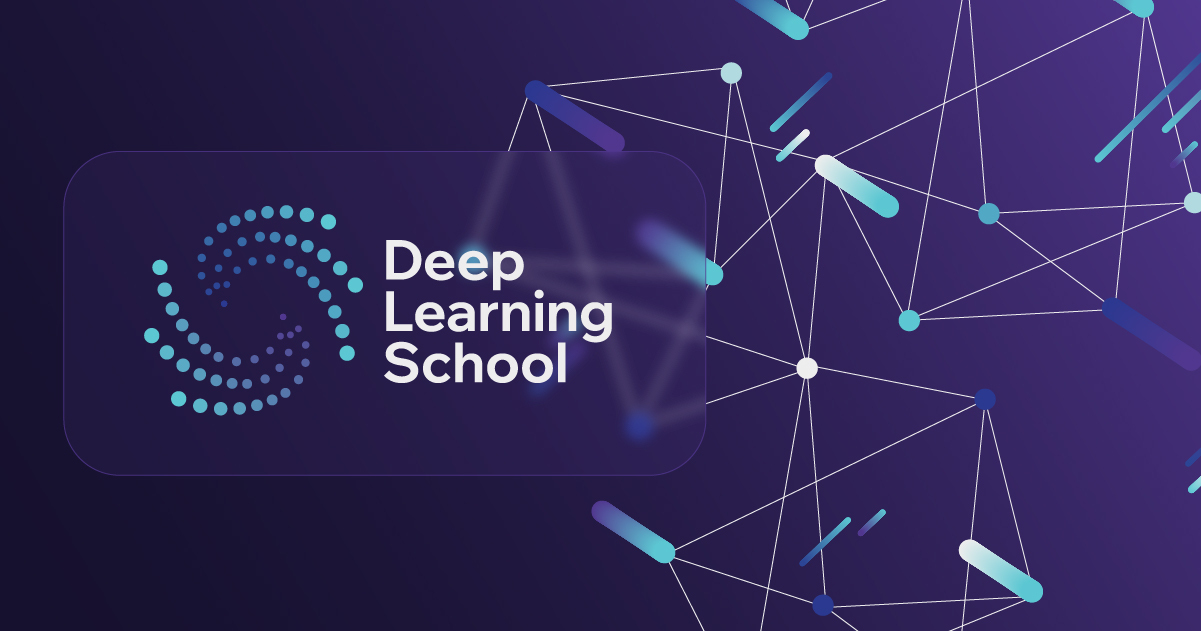


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [ ]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Using Colab cache for faster access to the 'lfw-dataset' dataset.
Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Using Colab cache for faster access to the 'lfw-attributes' dataset.
Path to dataset files: /kaggle/input/lfw-attributes


In [ ]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [ ]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [ ]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(attrs, images, test_size=0.2)

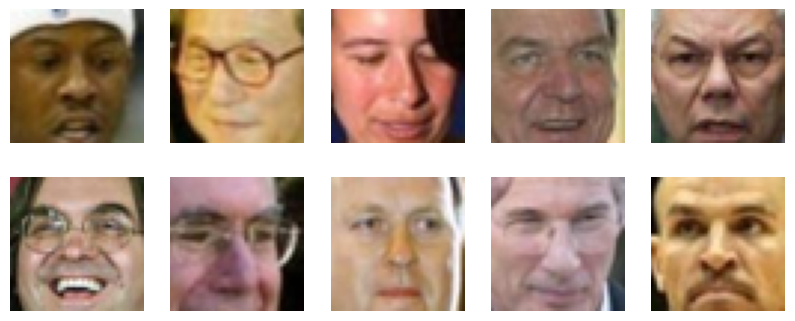

In [ ]:
num_show_images = 10

plt.figure(figsize=(10, 4))
for i in range(num_show_images):
    plt.subplot(2, num_show_images // 2, i + 1)
    plt.imshow(y_valid[i])
    plt.axis('off')

plt.show()

## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



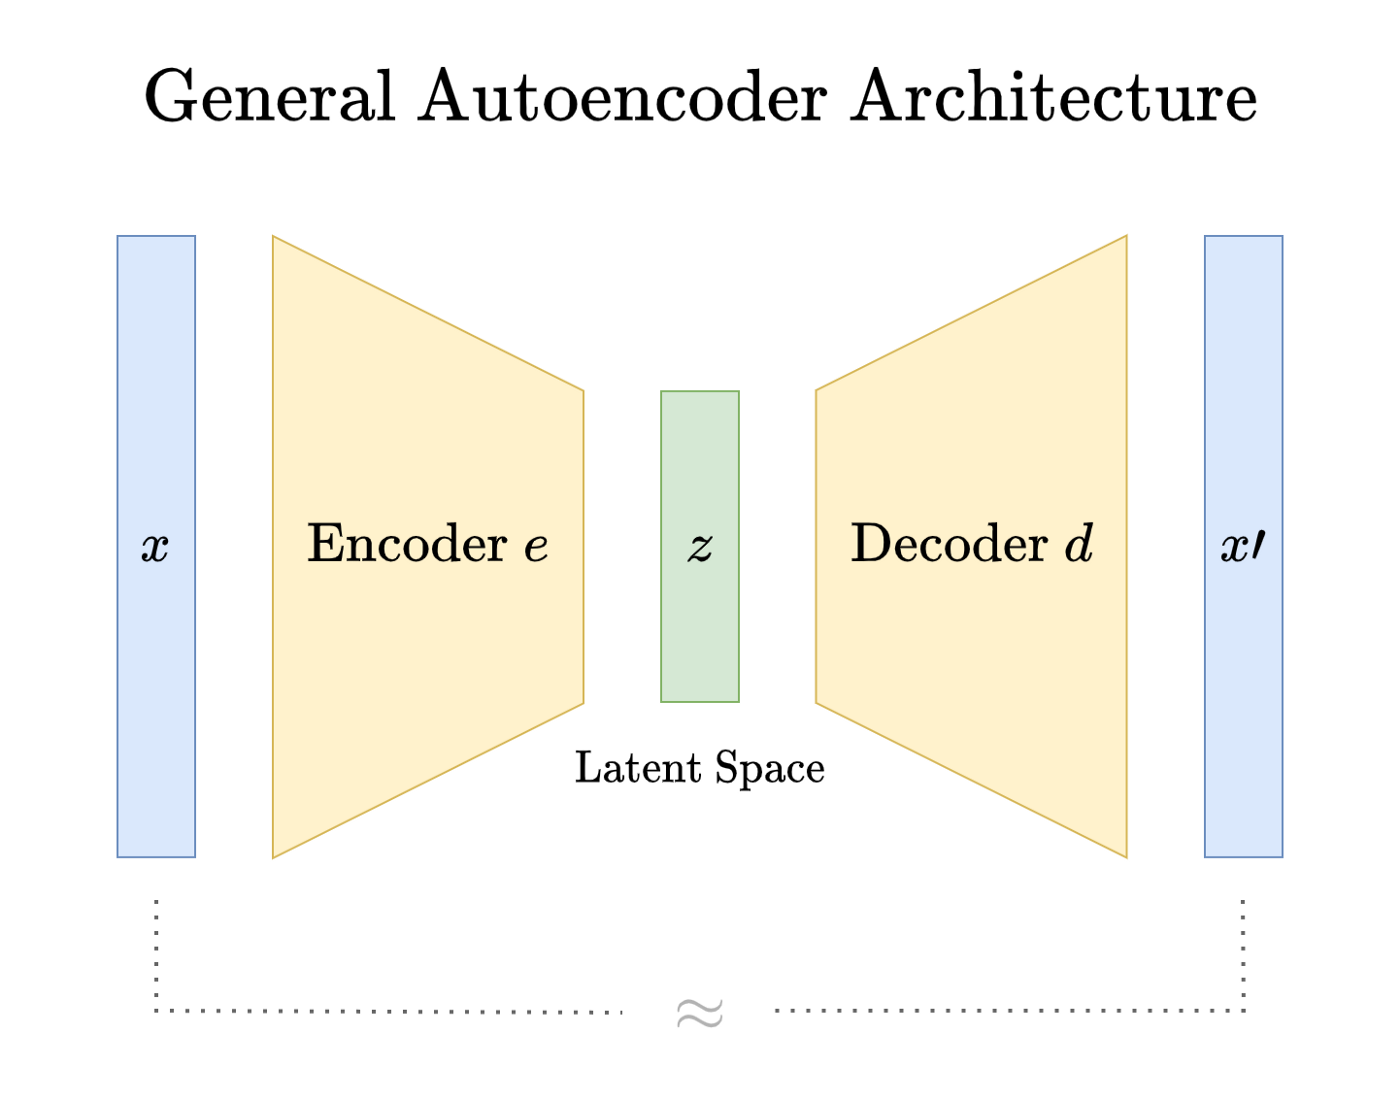

In [ ]:
dim_code = 256

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=dim_code):
        super().__init__()

        # ---------- Encoder ----------
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),   # 45x45
            nn.ReLU(),
            nn.MaxPool2d(2),                  # 22x22

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)                   # 11x11
        )

        self.encoder_fc = nn.Linear(32 * 11 * 11, latent_dim)

        # ---------- Decoder ----------
        self.decoder_fc = nn.Linear(latent_dim, 32 * 11 * 11)

        self.decoder_cnn = nn.Sequential(
            nn.Upsample(scale_factor=2),      # 11 → 22
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),      # 22 → 44
            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.reshape(z.size(0), 32, 11, 11)
        x = self.decoder_cnn(x)
        x = nn.functional.pad(x, (0, 1, 0, 1))  # → 45x45
        return x

    def forward(self, x):
      z = self.encoder_cnn(x)
      z = z.reshape(x.size(0), -1)
      z = self.encoder_fc(z)
      x = self.decode(z)
      return x, z

In [ ]:
from sklearn.metrics import mean_squared_error

input_dim = 45 * 45 * 3

criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32) / 255.0

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        x = torch.from_numpy(x).permute(2, 0, 1)
        return x

In [ ]:
def train_autoencoder(model, train_loader, valid_loader, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # -------- TRAIN --------
        model.train()
        train_loss = 0

        for x in train_loader:
            x = x.to(device)

            optimizer.zero_grad()
            recon, _ = model(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # -------- VALID --------
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x in valid_loader:
                x = x.to(device)
                recon, _ = model(x)
                loss = criterion(recon, x)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:03d} | Train: {train_loss:.5f} | Val: {val_loss:.5f}")

    return train_losses, val_losses

In [ ]:
batch_size = 64

train_dataset = ImageDataset(y_train)
valid_dataset = ImageDataset(y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Call the training function
train_losses, val_losses = train_autoencoder(
    autoencoder, train_loader, valid_loader, epochs=100
)

Epoch 001 | Train: 0.02431 | Val: 0.01704
Epoch 002 | Train: 0.01571 | Val: 0.01476
Epoch 003 | Train: 0.01419 | Val: 0.01375
Epoch 004 | Train: 0.01344 | Val: 0.01331
Epoch 005 | Train: 0.01303 | Val: 0.01288
Epoch 006 | Train: 0.01270 | Val: 0.01261
Epoch 007 | Train: 0.01249 | Val: 0.01251
Epoch 008 | Train: 0.01233 | Val: 0.01230
Epoch 009 | Train: 0.01220 | Val: 0.01222
Epoch 010 | Train: 0.01206 | Val: 0.01217
Epoch 011 | Train: 0.01200 | Val: 0.01203
Epoch 012 | Train: 0.01190 | Val: 0.01195
Epoch 013 | Train: 0.01184 | Val: 0.01188
Epoch 014 | Train: 0.01178 | Val: 0.01184
Epoch 015 | Train: 0.01171 | Val: 0.01188
Epoch 016 | Train: 0.01166 | Val: 0.01175
Epoch 017 | Train: 0.01161 | Val: 0.01172
Epoch 018 | Train: 0.01157 | Val: 0.01167
Epoch 019 | Train: 0.01152 | Val: 0.01177
Epoch 020 | Train: 0.01155 | Val: 0.01163
Epoch 021 | Train: 0.01145 | Val: 0.01166
Epoch 022 | Train: 0.01144 | Val: 0.01156
Epoch 023 | Train: 0.01142 | Val: 0.01161
Epoch 024 | Train: 0.01138 | Val: 

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [ ]:
def show_reconstructions(model, loader, n=10):
    model.eval()
    x = next(iter(loader)).to(device)

    with torch.no_grad():
        recon, _ = model(x)

    x = x.cpu().permute(0, 2, 3, 1).numpy()
    recon = recon.cpu().permute(0, 2, 3, 1).numpy()

    plt.figure(figsize=(n * 2, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(x[i])
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i])
        plt.axis("off")
        if i == 0:
            plt.title("Reconstruction")

    plt.show()

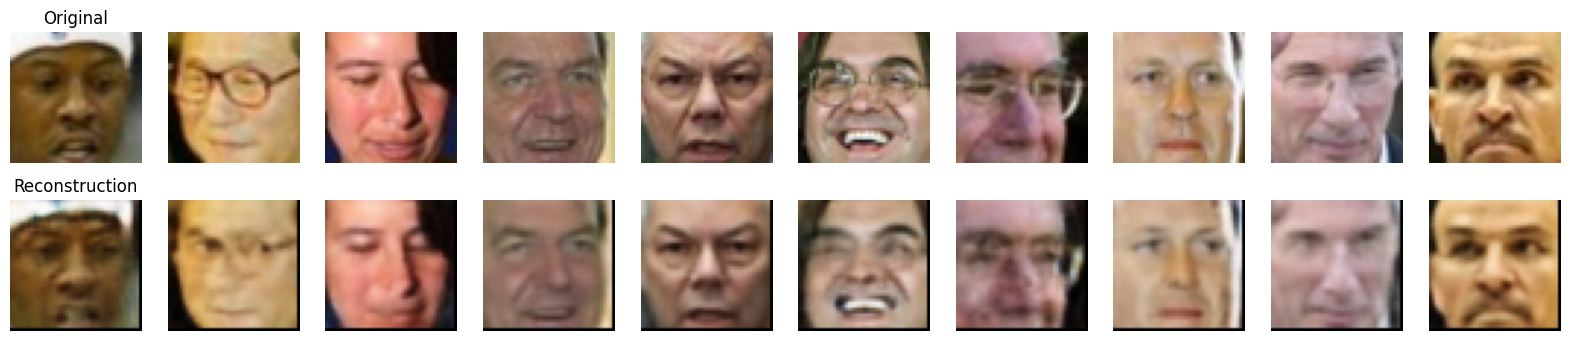

In [ ]:
show_reconstructions(autoencoder, valid_loader)

Что вы можете сказать про результат?

Модель обучилсь неплохо на 100 эпохах. При увеличении числа эпох качество становится всё лучше и лучше

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

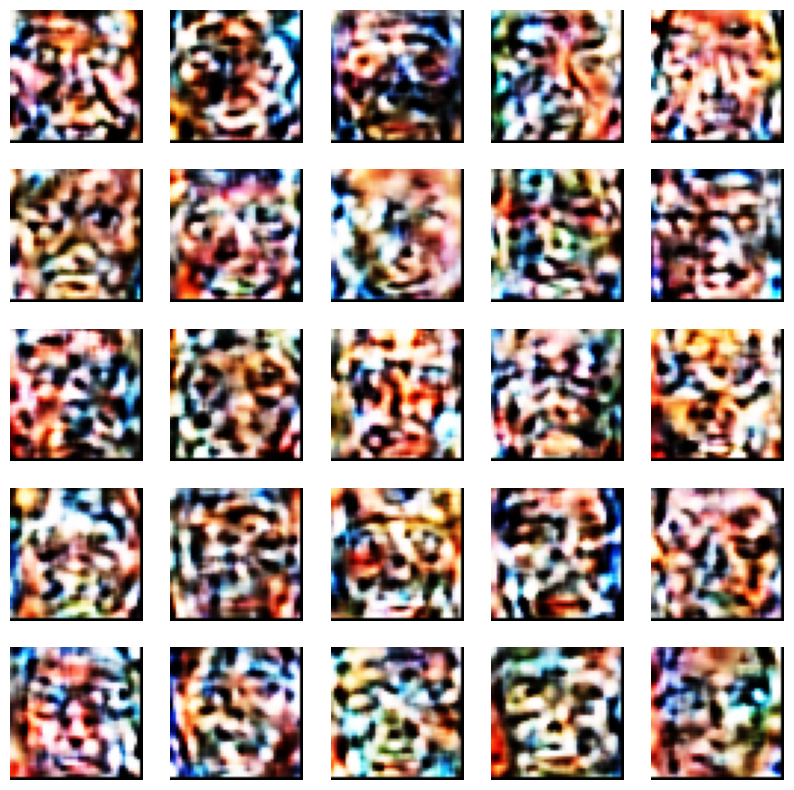

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code).astype(np.float32)
z_tensor = torch.tensor(z).to(device)

autoencoder.eval()
with torch.no_grad():
    generated = autoencoder.decode(z_tensor)

output = generated.cpu().permute(0, 2, 3, 1).numpy()
output = np.clip(output, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(output[i])
    plt.axis('off')
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
happy_images = images[attrs.loc[attrs['Smiling'] > 2.4].index]
sad_images = images[attrs.loc[attrs['Smiling'] < -2.0].index]

In [ ]:
happy_images.shape, sad_images.shape

((64, 45, 45, 3), (254, 45, 45, 3))

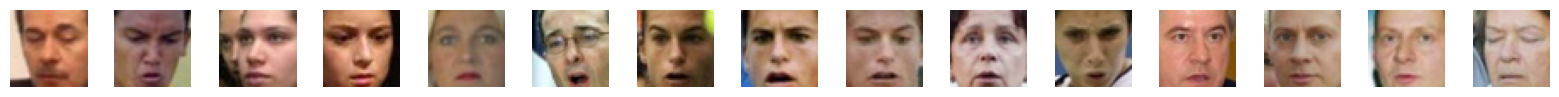

In [ ]:
num_images_to_show = 15

plt.figure(figsize=(20, 1))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sad_images[i])
    plt.axis('off')

plt.show()

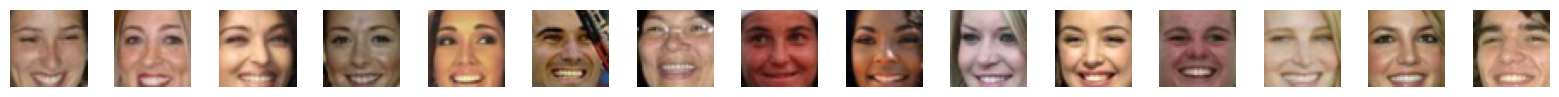

In [ ]:
plt.figure(figsize=(20, 1))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(happy_images[i])
    plt.axis('off')

plt.show()

In [ ]:
happy_images_15 = happy_images[:15]
sad_images_15 = sad_images[:15]

In [ ]:
happy_images_15.shape

(15, 45, 45, 3)

In [ ]:
happy_images_15_tensor = torch.tensor(happy_images_15.astype(np.float32) / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
sad_images_15_tensor = torch.tensor(sad_images_15.astype(np.float32) / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

autoencoder.eval()
with torch.no_grad():
    _, happy_images_15_laten = autoencoder(happy_images_15_tensor)
    _, sad_images_15_laten = autoencoder(sad_images_15_tensor)

In [ ]:
smile_vector = happy_images_15_laten.mean(dim=0) - sad_images_15_laten.mean(dim=0)

In [ ]:
smile_vector.shape

torch.Size([256])

In [ ]:
new_happy_latent = sad_images_15_laten + smile_vector

In [ ]:
new_happy_latent.shape

torch.Size([15, 256])

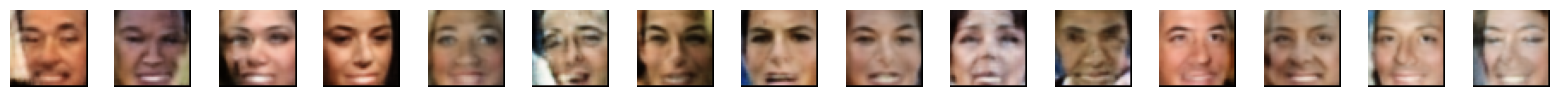

In [ ]:
autoencoder.eval()
with torch.no_grad():
    generated = autoencoder.decode(new_happy_latent)

output = generated.cpu().permute(0, 2, 3, 1).numpy()
output = np.clip(output, 0, 1)

plt.figure(figsize=(20, 1))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(output[i])
    plt.axis('off')

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20, in_channels=1):
        super().__init__()

        # ---------- Encoder ----------
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # H/2

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)           # H/4
        )

        self.flatten_dim = 32 * 7 * 7

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logsigma = nn.Linear(self.flatten_dim, latent_dim)

        # ---------- Decoder ----------
        self.decoder_fc = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 7 → 14
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),   # 14 → 28
            nn.Sigmoid()
        )

    # --------- Encoder ---------
    def encode(self, x):
        h = self.encoder_cnn(x)
        h = h.reshape(x.size(0), -1)

        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)   # log σ2

        return mu, logsigma

    # --------- Reparameterization ---------
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    # --------- Decoder ---------
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(z.size(0), 32, 7, 7)
        return self.decoder_cnn(h)

    # --------- Forward ---------
    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    return F.binary_cross_entropy(reconstruction, x, reduction='sum')

def loss_vae(x, mu, logsigma, reconstruction):
    recon_loss = log_likelihood(x, reconstruction)
    kl_loss = KL_divergence(mu, logsigma)
    return recon_loss + kl_loss

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

In [ ]:
def train_autoencoder_vae(model, train_loader, valid_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # -------- TRAIN --------
        model.train()
        train_loss = 0

        for batch in train_loader:
            x, _ = batch          # MNIST → (images, labels)
            x = x.to(device)

            optimizer.zero_grad()

            mu, logsigma, recon = model(x)
            loss = loss_vae(x, mu, logsigma, recon)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # -------- VALID --------
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                x, _ = batch
                x = x.to(device)

                mu, logsigma, recon = model(x)
                loss = loss_vae(x, mu, logsigma, recon)

                val_loss += loss.item()

        val_loss /= len(valid_loader.dataset)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch+1:03d} | "
            f"Train: {train_loss:.4f} | "
            f"Val: {val_loss:.4f}"
        )

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_autoencoder_vae(
    autoencoder, train_loader, test_loader, criterion, optimizer, epochs=100
)

Epoch 001 | Train: 185.7746 | Val: 127.7817
Epoch 002 | Train: 129.7125 | Val: 115.2072
Epoch 003 | Train: 121.6360 | Val: 108.6118
Epoch 004 | Train: 117.8596 | Val: 106.4048
Epoch 005 | Train: 115.3692 | Val: 104.0375
Epoch 006 | Train: 113.6263 | Val: 102.2880
Epoch 007 | Train: 112.4114 | Val: 101.7319
Epoch 008 | Train: 111.4714 | Val: 100.8639
Epoch 009 | Train: 110.7606 | Val: 100.2230
Epoch 010 | Train: 110.2012 | Val: 99.7724
Epoch 011 | Train: 109.7348 | Val: 99.3564
Epoch 012 | Train: 109.3091 | Val: 98.9749
Epoch 013 | Train: 109.0005 | Val: 99.3558
Epoch 014 | Train: 108.6452 | Val: 99.2252
Epoch 015 | Train: 108.4164 | Val: 98.5237
Epoch 016 | Train: 108.1576 | Val: 98.3617
Epoch 017 | Train: 107.9481 | Val: 98.1870
Epoch 018 | Train: 107.7336 | Val: 97.8088
Epoch 019 | Train: 107.5894 | Val: 97.7352
Epoch 020 | Train: 107.3892 | Val: 97.3872
Epoch 021 | Train: 107.1920 | Val: 97.2117
Epoch 022 | Train: 107.0194 | Val: 96.9658
Epoch 023 | Train: 106.9110 | Val: 96.7939
Ep

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def show_reconstructions_vae(model, dataloader, num_images=8):
    model.eval()

    with torch.no_grad():
        # берём первый batch
        x, _ = next(iter(dataloader))
        x = x.to(device)

        mu, logsigma, recon = model(x)

    x = x.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(2 * num_images, 4))

    for i in range(num_images):
        # Оригиналы (верх)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        # Реконструкции (низ)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(recon[i, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Reconstruction")

    plt.tight_layout()
    plt.show()

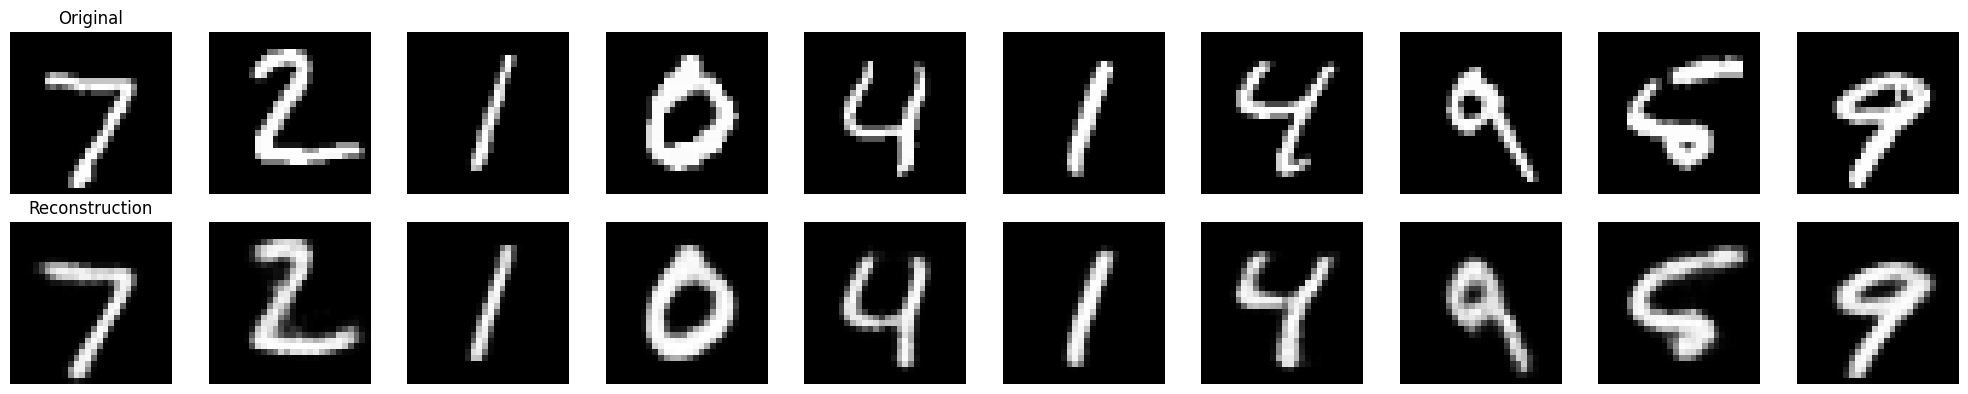

In [ ]:
show_reconstructions_vae(autoencoder, test_loader, num_images=10)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

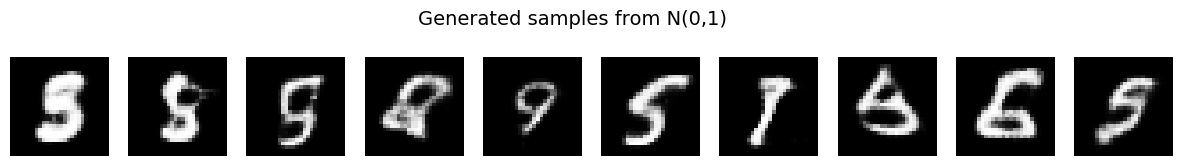

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.random.normal(0, 1, size=(10, 20))
z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

autoencoder.eval()
with torch.no_grad():
    generated = autoencoder.decode(z_tensor)

generated = generated.cpu()

plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated[i, 0], cmap='gray')
    plt.axis('off')

plt.suptitle("Generated samples from N(0,1)", fontsize=14)
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
latents = []
labels_list = []

autoencoder.eval()
with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)

        mu, logsigma, _ = autoencoder(x)
        latents.append(mu.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

latents = np.concatenate(latents, axis=0)   # (N, latent_dim)
labels = np.concatenate(labels_list, axis=0) # (N,)

In [ ]:
from sklearn.manifold import TSNE

num_points = 3000
indices = np.random.choice(len(latents), num_points, replace=False)

latents_subset = latents[indices]
labels_subset = labels[indices]

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

latents_2d = tsne.fit_transform(latents_subset)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


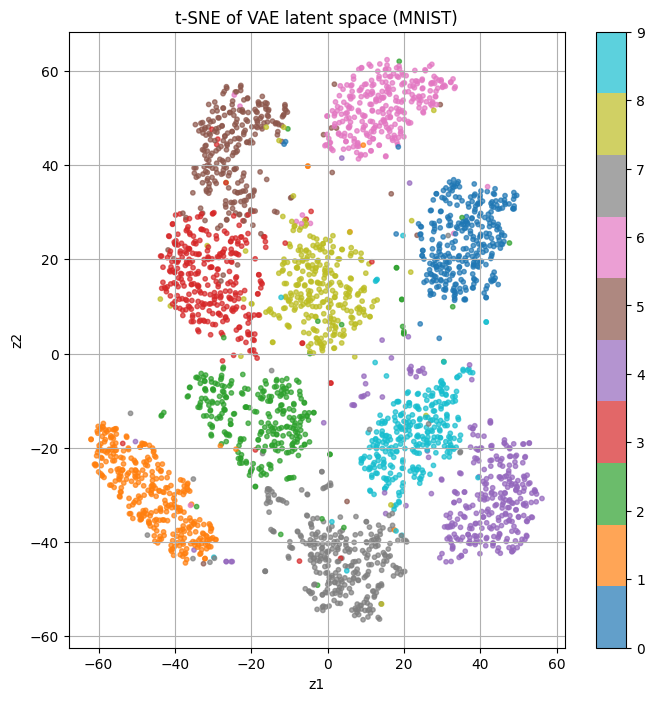

In [ ]:
plt.figure(figsize=(8, 8))

scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=labels_subset,
    cmap='tab10',
    s=10,
    alpha=0.7
)

plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of VAE latent space (MNIST)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

Что вы думаете о виде латентного представления? Модель хорошо обучилась, так как нет явной смеси из разных чисел

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super().__init__()

        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # ---------- Encoder ----------
        # Класс будем конкатенировать как feature map
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1 + num_classes, 16, 3, padding=1),  # + class channels
            nn.ReLU(),
            nn.MaxPool2d(2),                               # 14x14

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)                                # 7x7
        )

        self.flatten_dim = 32 * 7 * 7

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logsigma = nn.Linear(self.flatten_dim, latent_dim)

        # ---------- Decoder ----------
        self.decoder_fc = nn.Linear(latent_dim + num_classes, self.flatten_dim)

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 7 → 14
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),   # 14 → 28
            nn.Sigmoid()
        )

    # ---------- Encoder ----------
    def encode(self, x, class_num):
        """
        x: (N, 1, 28, 28)
        class_num: (N,)
        """
        # one-hot
        y = F.one_hot(class_num, self.num_classes).float()
        y = y.unsqueeze(-1).unsqueeze(-1)          # (N, C, 1, 1)
        y = y.expand(-1, -1, 28, 28)                # (N, C, 28, 28)

        x_cond = torch.cat([x, y], dim=1)           # (N, 1+C, 28, 28)

        h = self.encoder_cnn(x_cond)
        h = h.view(x.size(0), -1)

        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)

        return mu, logsigma, self.num_classes

    # ---------- Reparameterization ----------
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    # ---------- Decoder ----------
    def decode(self, z, class_num):
        """
        z: (N, latent_dim)
        class_num: (N,)
        """
        y = F.one_hot(class_num, self.num_classes).float()
        z_cond = torch.cat([z, y], dim=1)

        h = self.decoder_fc(z_cond)
        h = h.view(z.size(0), 32, 7, 7)

        reconstruction = self.decoder_cnn(h)
        return reconstruction

    # ---------- Forward ----------
    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [ ]:
autoencoder_cvae = CVAE().to(device)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def sample_digits_by_class(model, class_label, num_samples=10, latent_dim=20):
    """
    Генерирует num_samples изображений заданного класса
    """
    model.eval()

    z = torch.randn(num_samples, latent_dim).to(device)

    labels = torch.full(
        (num_samples,),
        class_label,
        dtype=torch.long,
        device=device
    )

    with torch.no_grad():
        generated = model.decode(z, labels)

    return generated.cpu()

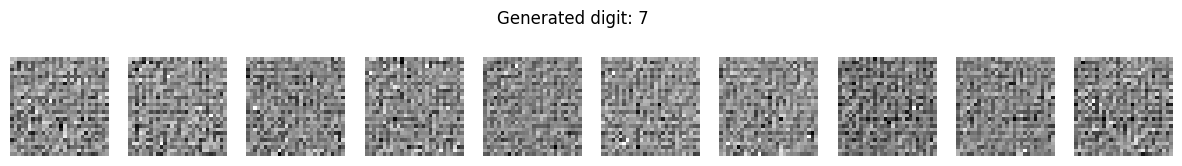

In [ ]:
generated_7 = sample_digits_by_class(
    autoencoder_cvae,
    class_label=7,
    num_samples=10,
    latent_dim=20
)

plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_7[i, 0], cmap='gray')
    plt.axis('off')

plt.suptitle("Generated digit: 7")
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
latents = []
labels_all = []

autoencoder_cvae.eval()
with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        labels = labels.to(device)

        mu, logsigma, _ = autoencoder_cvae.encode(x, labels)
        latents.append(mu.cpu().numpy())
        labels_all.append(labels.cpu().numpy())

latents = np.concatenate(latents, axis=0)   # (N, latent_dim)
labels_all = np.concatenate(labels_all, axis=0)

In [ ]:
num_points = 3000
idx = np.random.choice(len(latents), num_points, replace=False)

latents_subset = latents[idx]
labels_subset = labels_all[idx]

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

latents_2d = tsne.fit_transform(latents_subset)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


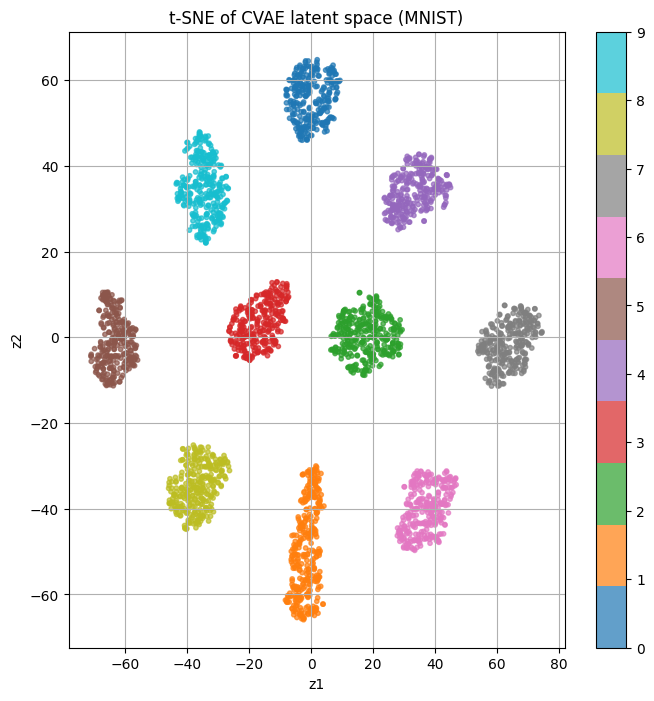

In [ ]:
plt.figure(figsize=(8, 8))

scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=labels_subset,
    cmap='tab10',
    s=10,
    alpha=0.7
)

plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of CVAE latent space (MNIST)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE? CVAE лучше справилась с кластеризацией

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>